# Using 1Inch to Estimate Slippage

We can start caching the output of the 1Inch `quote` API and use that for our slippage calculation.

In [37]:
from src.network.oneinchquotes import OneInchQuotes
from src.configs import config

import matplotlib.pyplot as plt
from dotenv import load_dotenv
import os
import numpy as np

from src.utils.plotting import *

%load_ext autoreload
%autoreload 2

load_dotenv()
INCH_API_KEY = os.getenv("1INCH_API_KEY")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [130]:
oneinchquotes = OneInchQuotes(INCH_API_KEY, config.ALL, calls=20)
protocols = oneinchquotes.protocols()["protocols"]
protocols[:5]

[{'id': 'UNISWAP_V1',
  'title': 'Uniswap V1',
  'img': 'https://cdn.1inch.io/liquidity-sources-logo/uniswap.png',
  'img_color': 'https://cdn.1inch.io/liquidity-sources-logo/uniswap_color.png'},
 {'id': 'UNISWAP_V2',
  'title': 'Uniswap V2',
  'img': 'https://cdn.1inch.io/liquidity-sources-logo/uniswap.png',
  'img_color': 'https://cdn.1inch.io/liquidity-sources-logo/uniswap_color.png'},
 {'id': 'SUSHI',
  'title': 'SushiSwap',
  'img': 'https://cdn.1inch.io/liquidity-sources-logo/sushiswap.png',
  'img_color': 'https://cdn.1inch.io/liquidity-sources-logo/sushiswap_color.png'},
 {'id': 'MOONISWAP',
  'title': 'Mooniswap',
  'img': 'https://cdn.1inch.io/liquidity-sources-logo/mooniswap.png',
  'img_color': 'https://cdn.1inch.io/liquidity-sources-logo/mooniswap_color.png'},
 {'id': 'BALANCER',
  'title': 'Balancer',
  'img': 'https://cdn.1inch.io/liquidity-sources-logo/balancer.png',
  'img_color': 'https://cdn.1inch.io/liquidity-sources-logo/balancer_color.png'}]

In [10]:
res = oneinchquotes.quote(
    config.ALL["USDC"]["address"], config.ALL["WETH"]["address"], int(1e6)
)
res.price

1940.3729742893147

In [128]:
# Construct a curve of quotes to estimate price impact = f(trade size)
in_token, out_token = "TUSD", "WETH"
res = oneinchquotes.quotes_for_pair((in_token, out_token))
res

[QuoteResponse(src='TUSD', dst='WETH', in_amount=1000000000000000000, out_amount=475777682634410, gas=184952, timestamp=1699995914, in_decimals=18, out_decimals=18, price=0.00047577768263441, protocols=[[[{'name': 'UNISWAP_V2', 'part': 100, 'fromTokenAddress': '0x0000000000085d4780b73119b644ae5ecd22b376', 'toTokenAddress': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'}]]]),
 QuoteResponse(src='TUSD', dst='WETH', in_amount=2636650898730358272, out_amount=1254323327985702, gas=184952, timestamp=1699995916, in_decimals=18, out_decimals=18, price=0.0004757259782058003, protocols=[[[{'name': 'UNISWAP_V2', 'part': 100, 'fromTokenAddress': '0x0000000000085d4780b73119b644ae5ecd22b376', 'toTokenAddress': '0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2'}]]]),
 QuoteResponse(src='TUSD', dst='WETH', in_amount=6951927961775605760, out_amount=3306265372272567, gas=184952, timestamp=1699995917, in_decimals=18, out_decimals=18, price=0.00047558970553948426, protocols=[[[{'name': 'UNISWAP_V2', 'part': 100, 

In [141]:
len(res[-1].protocols)

3

In [143]:
res[-1].protocols[0]

[[{'name': 'CURVE',
   'part': 4,
   'fromTokenAddress': '0x0000000000085d4780b73119b644ae5ecd22b376',
   'toTokenAddress': '0xdac17f958d2ee523a2206206994597c13d831ec7'},
  {'name': 'PANCAKESWAP_V3',
   'part': 22,
   'fromTokenAddress': '0x0000000000085d4780b73119b644ae5ecd22b376',
   'toTokenAddress': '0xdac17f958d2ee523a2206206994597c13d831ec7'},
  {'name': 'SWERVE',
   'part': 36,
   'fromTokenAddress': '0x0000000000085d4780b73119b644ae5ecd22b376',
   'toTokenAddress': '0xdac17f958d2ee523a2206206994597c13d831ec7'},
  {'name': 'CURVE',
   'part': 38,
   'fromTokenAddress': '0x0000000000085d4780b73119b644ae5ecd22b376',
   'toTokenAddress': '0xdac17f958d2ee523a2206206994597c13d831ec7'}],
 [{'name': 'BALANCER_V2',
   'part': 6,
   'fromTokenAddress': '0xdac17f958d2ee523a2206206994597c13d831ec7',
   'toTokenAddress': '0x6b175474e89094c44da98b954eedeac495271d0f'},
  {'name': 'CURVE',
   'part': 8,
   'fromTokenAddress': '0xdac17f958d2ee523a2206206994597c13d831ec7',
   'toTokenAddress': '

In [131]:
def plot_price_impact_1inch(res, in_token, out_token, fn: str = None):
    base_price = res[0].price  # assume that the first quote is the base price
    prices = [r.price for r in res]
    price_impact = [100 * (p - base_price) / base_price for p in prices]
    in_amounts = [r.in_amount / (10**r.in_decimals) for r in res]

    f, ax = plt.subplots(figsize=(10, 5))
    ax.scatter(in_amounts, price_impact, s=10, c="royalblue")
    ax.set_xscale("log")
    ax.set_title(f"Price Impact for Swapping {in_token} into {out_token}")
    ax.set_ylabel("Price Impact (%)")
    ax.set_xlabel(f"Trade Size ({in_token})")

    f.tight_layout()

    if fn:
        plt.savefig(fn, bbox_inches="tight", dpi=300)
        plt.close()  # don't show

    return f

def plot_price_1inch(res, in_token, out_token, fn: str = None):
    prices = [r.price for r in res]
    in_amounts = [r.in_amount / (10**r.in_decimals) for r in res]

    f, ax = plt.subplots(figsize=(10, 5))
    ax.scatter(in_amounts, prices, s=10, c="royalblue")
    ax.set_xscale("log")
    ax.set_title(f"Prices for Swapping {in_token} into {out_token}")
    ax.set_ylabel("Exchange Rate (out/in)")
    ax.set_xlabel(f"Trade Size ({in_token})")

    f.tight_layout()

    if fn:
        plt.savefig(fn, bbox_inches="tight", dpi=300)
        plt.close()  # don't show

    return f

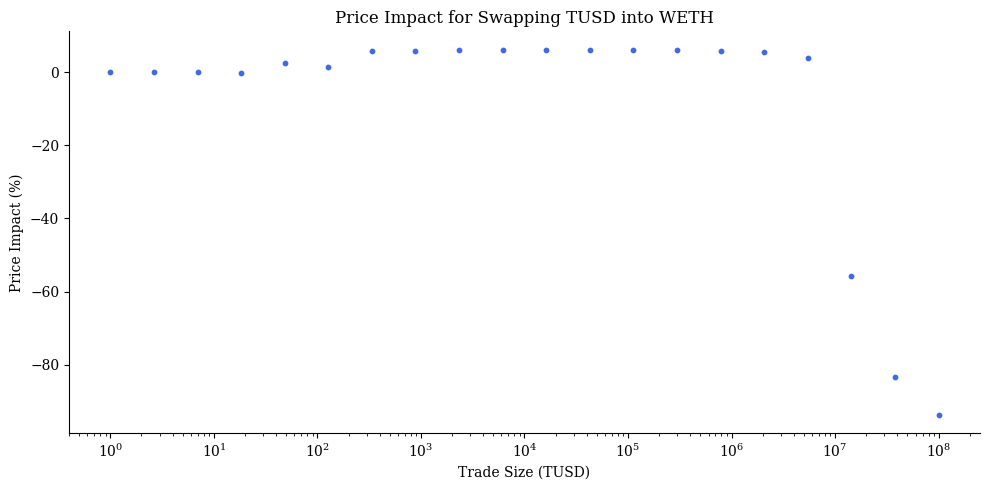

In [134]:
_ = plot_price_impact_1inch(res, in_token, out_token)

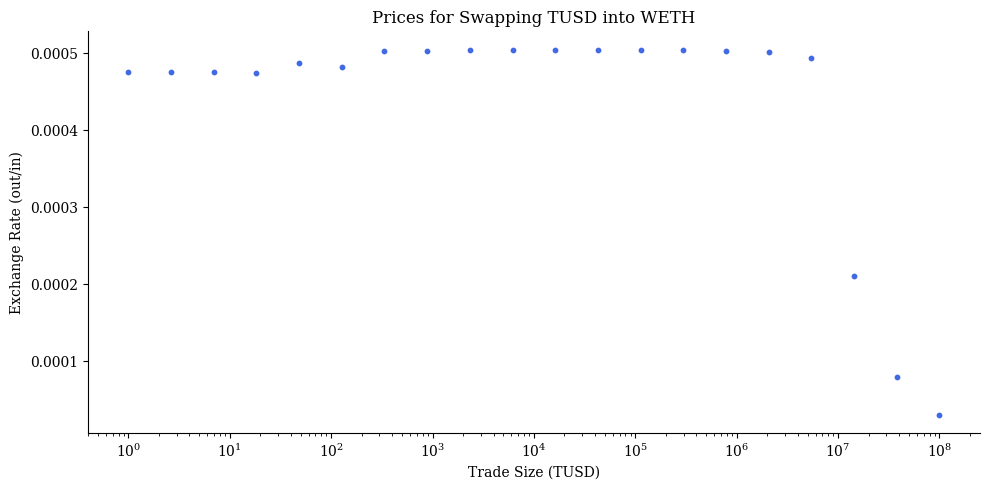

In [133]:
_ = plot_price_1inch(res, in_token, out_token)

In [48]:
len(res)

20